Task 1: Dataset Selection and Preparation (20 Marks)

1. Find a suitable dataset in Kaggle. The dataset must contain at least one column with natural text (e.g., reviews, comments, descriptions) for sentiment analysis.
2. Load the dataset as a Pandas DataFrame.
3. Use Pandas methods to display basic information about the dataset, such as its data types, and a summary of numerical columns.
4. Identify and handle missing values appropriately. Explain your chosen strategy (e.g., filling with a default value, dropping rows, using interpolation).

In [1]:
# -------------------------------
# Task 1: Dataset Selection & Preparation
# -------------------------------

import pandas as pd

# 1) Load dataset
file_path = r"C:\Users\User\songs_normalize.csv"
df = pd.read_csv(file_path)

# 2) Display first few rows
print("1) First 5 rows of dataset:")
print(df.head(), "\n")

# 3) Basic info about dataset
print("2) Dataset Info:")
print(df.info(), "\n")

# Summary statistics for numerical columns
print("3) Summary statistics (numerical):")
print(df.describe(), "\n")

# 4) Check missing values
print("4) Missing values per column:")
print(df.isnull().sum(), "\n")

# ----- Handling Missing Values -----
# Drop rows where 'song' or 'artist' is missing (needed for NLP later)
df = df.dropna(subset=["song", "artist"])

# Fill missing numerical values with median (robust to outliers)
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with "Unknown"
cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Verify cleaning
print("5) Missing values after cleaning:")
print(df.isnull().sum(), "\n")

print("✅ Task 1 complete. Cleaned dataset is ready for analysis.")


1) First 5 rows of dataset:
           artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   
3          78         0.551   0.913    0    -4.063     0       0.0466   
4          65         0.614   0.928    8    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0

Task 2: Data Aggregation and Analysis (20 Marks)

1. Analyse the trends in the dataset by performing at least FIVE (5) aggregations on the dataset.
2. Explain why you chose these aggregations and what insights you hoped to discover.

In [2]:
# -------------------------------
# Task 2: Data Aggregation & Analysis (with numbering)
# -------------------------------

import pandas as pd


# 1) Average song duration per year
avg_duration_per_year = df.groupby("year")["duration_ms"].mean().reset_index()
avg_duration_per_year.index = avg_duration_per_year.index + 1  # start index at 1
print("1) Average Song Duration per Year:\n", avg_duration_per_year.head(), "\n")

# 2) Most frequent artists (top 10 by number of songs in dataset)
top_artists = df["artist"].value_counts().head(10).reset_index()
top_artists.columns = ["artist", "count"]
top_artists.index = top_artists.index + 1
print("2) Top 10 Most Frequent Artists:\n", top_artists, "\n")

# 3) Average popularity score per year
avg_popularity_year = df.groupby("year")["popularity"].mean().reset_index()
avg_popularity_year.index = avg_popularity_year.index + 1
print("3) Average Popularity per Year:\n", avg_popularity_year.head(), "\n")

# 4) Distribution of songs by genre
songs_per_genre = df["genre"].value_counts().reset_index()
songs_per_genre.columns = ["genre", "count"]
songs_per_genre.index = songs_per_genre.index + 1
print("4) Distribution of Songs by Genre:\n", songs_per_genre.head(), "\n")

# 5) Average tempo by year
avg_tempo_year = df.groupby("year")["tempo"].mean().reset_index()
avg_tempo_year.index = avg_tempo_year.index + 1
print("5) Average Tempo per Year:\n", avg_tempo_year.head(), "\n")

# 6) Bonus: Top 10 most danceable songs
top_danceable = df.sort_values(by="danceability", ascending=False)[["song", "artist", "danceability"]].head(10)
top_danceable = top_danceable.reset_index(drop=True)
top_danceable.index = top_danceable.index + 1
print("6) Top 10 Most Danceable Songs:\n", top_danceable, "\n")


1) Average Song Duration per Year:
    year    duration_ms
1  1998  215466.000000
2  1999  253384.631579
3  2000  249993.067568
4  2001  242450.064815
5  2002  253549.077778 

2) Top 10 Most Frequent Artists:
             artist  count
1          Rihanna     25
2            Drake     23
3           Eminem     21
4    Calvin Harris     20
5   Britney Spears     19
6     David Guetta     18
7      Chris Brown     17
8       Kanye West     17
9          Beyoncé     16
10    Taylor Swift     16 

3) Average Popularity per Year:
    year  popularity
1  1998   49.000000
2  1999   64.921053
3  2000   58.554054
4  2001   59.407407
5  2002   62.400000 

4) Distribution of Songs by Genre:
                    genre  count
1                    pop    428
2           hip hop, pop    277
3      hip hop, pop, R&B    244
4  pop, Dance/Electronic    221
5               pop, R&B    178 

5) Average Tempo per Year:
    year       tempo
1  1998   81.125000
2  1999  122.705000
3  2000  112.927041
4  2001  

Task 3: Sentiment Analysis with Hugging Face (30 Marks)

1. Use the transformers library to instantiate a sentiment analysis pipeline. You can use the nlptown/bert-base-multilingual-uncased-sentiment model or another suitable model from the Hugging Face Hub.
2. Iterate through the designated text column and use the pipeline to predict a sentiment score for each entry.
3. Create a new column in your DataFrame to store these sentiment scores. Use this new column to find and display the top 5 entries with the highest sentiment score and the bottom 5 with the lowest.

In [11]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from IPython.display import display

# Load dataset
df = pd.read_csv("songs_normalize.csv")

# 1. Instantiate sentiment analysis pipeline (use GPU if available)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=0   # GPU = 0, CPU = -1
)

# 2. Apply sentiment analysis with progress bar
results = []
for song in tqdm(df["song"].tolist(), desc="Processing songs", unit="song"):
    results.append(sentiment_pipeline(song)[0])

# 3. Extract numeric sentiment scores (1–5 stars)
df["sentiment_score"] = [int(r["label"].split()[0]) for r in results]

# 4. Save updated dataset for Task 4
df.to_csv("songs_with_sentiment.csv", index=False)

# 5. Show top 5 positive and bottom 5 negative entries as DataFrames
top5 = df.nlargest(5, "sentiment_score")[["artist", "song", "sentiment_score"]]
bottom5 = df.nsmallest(5, "sentiment_score")[["artist", "song", "sentiment_score"]]

print("\n✅ Top 5 Positive Songs:")
display(top5)

print("\n❌ Bottom 5 Negative Songs:")
display(bottom5)


Device set to use cpu
Processing songs: 100%|██████████| 2000/2000 [01:46<00:00, 18.79song/s]


✅ Top 5 Positive Songs:


,artist,song,sentiment_score
2,Faith Hill,Breathe,5
3,Bon Jovi,It's My Life,5
4,*NSYNC,Bye Bye Bye,5
6,Eminem,The Real Slim Shady,5
7,Robbie Williams,Rock DJ,5



❌ Bottom 5 Negative Songs:


,artist,song,sentiment_score
14,Melanie C,Never Be The Same Again,1
21,Tom Jones,Sexbomb,1
24,Melanie C,I Turn To You,1
26,Darude,Sandstorm,1
41,Toni Braxton,He Wasn't Man Enough,1


Task 4: Interactive Visualisation with Plotly (20 Marks)

1. Design and create at least THREE (3) stunning, interactive visualizations using the Plotly library.
2. The visualizations should represent your findings from Task 2 and Task 3
3. Provide a brief interpretation for each visualization, explaining what the plot reveals about the data.

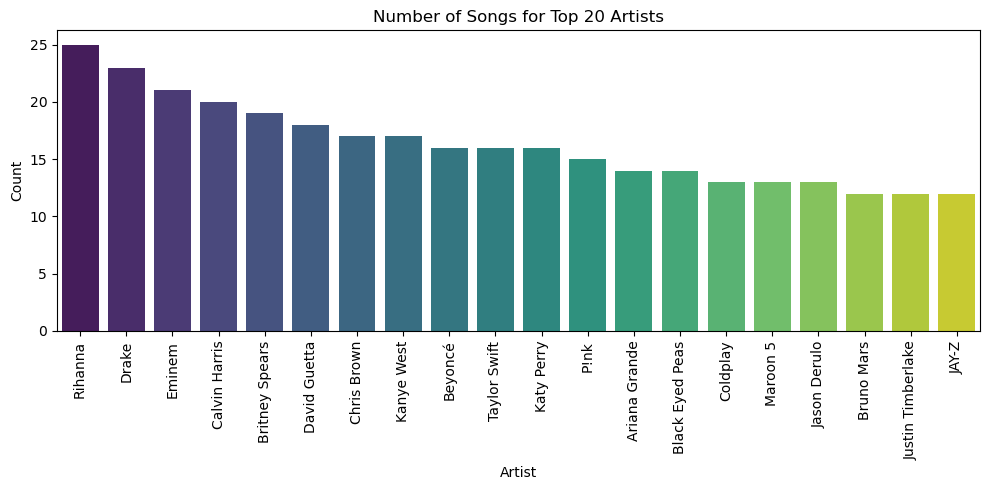

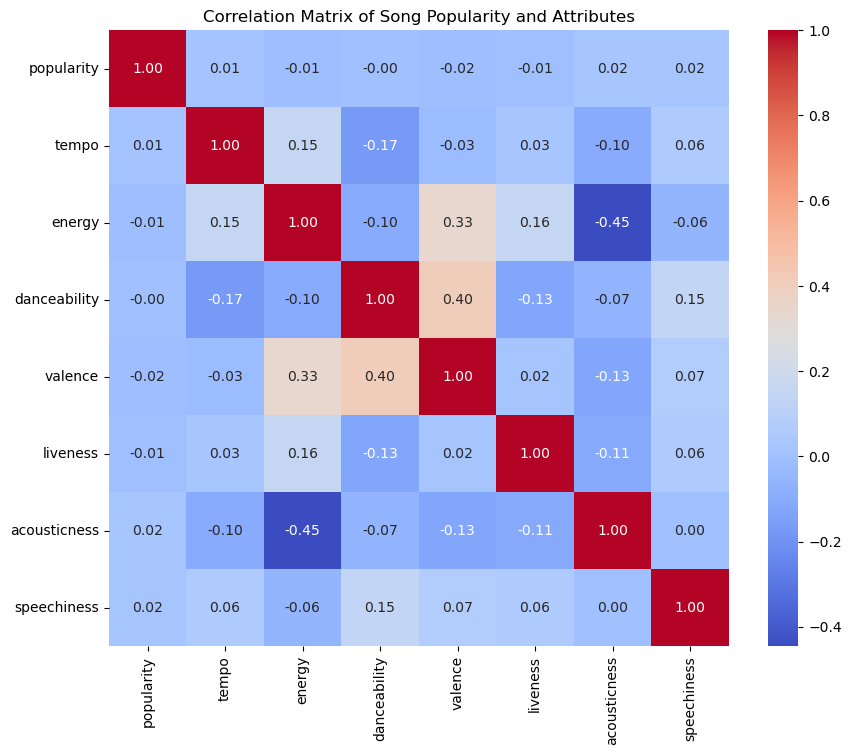

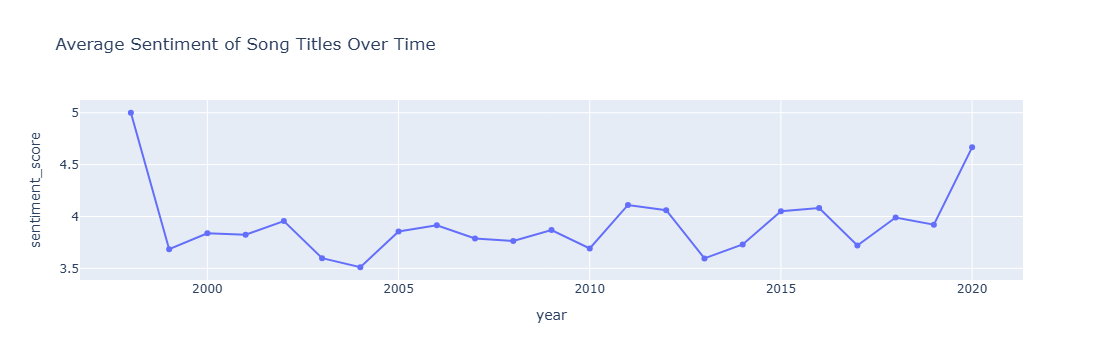

In [20]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Load dataset
try:
    df = pd.read_csv("songs_with_sentiment.csv")
except FileNotFoundError:
    print("Error: 'songs_with_sentiment.csv' not found. Ensure the file is in the same directory.")
    exit()

# Ensure sentiment_score exists
if "sentiment_score" not in df.columns:
    raise ValueError("⚠️ Please run Task 3 first to generate the 'sentiment_score' column!")

# Ensure correlation columns exist
correlation_columns = ['popularity', 'tempo', 'energy', 'danceability', 'valence', 'liveness', 'acousticness', 'speechiness']
missing_columns = [col for col in correlation_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"⚠️ Missing columns in dataset: {missing_columns}")

# =============================
# Visualization 1: Number of Songs for Top 20 Artists
# =============================
# Count the number of songs per artist and select top 20
top_artists = df['artist'].value_counts().head(20)

# Create bar plot with updated seaborn syntax to avoid FutureWarning
plt.figure(figsize=(10, 5))
sns.barplot(x=top_artists.index, y=top_artists.values, hue=top_artists.index, palette='viridis', legend=False)
plt.xlabel('Artist')
plt.ylabel('Count')
plt.title('Number of Songs for Top 20 Artists')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# =============================
# Visualization 2: Correlation Matrix of Song Popularity and Attributes
# =============================
# Calculate correlation matrix
correlation_matrix = df[correlation_columns].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Song Popularity and Attributes')
plt.show()

# =============================
# Visualization 3: Sentiment Trend Over Time
# =============================
sentiment_by_year = df.groupby("year")["sentiment_score"].mean().reset_index()

fig3 = px.line(
    sentiment_by_year,
    x="year",
    y="sentiment_score",
    title="Average Sentiment of Song Titles Over Time",
    markers=True
)
fig3.show()